In [79]:
from sklearn import model_selection, svm
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import classification_report, average_precision_score, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
#from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_curve, roc_auc_score

import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.layers import Conv2D
from keras.layers import Conv1D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras import optimizers
from keras.layers import Conv1D
import numpy as np
import pandas as pd
import scipy
import sklearn
import os
from keras.optimizers import SGD #Stochastic Gradient Descent Optimizer


In [2]:
import warnings
warnings.filterwarnings('ignore')

### Data Extraction and Preparation for Chest Data and Wrist Data

##### Personal Infromation Extraction of Subjects

##### Data Ingestion

In [3]:
%%time
main_data=pd.read_csv(r"SUBJECTS_10_Data.csv",sep=',',encoding="utf-8",error_bad_lines=False,low_memory = False)
print(main_data.shape)

(40143599, 11)
Wall time: 3min 32s


In [4]:
main_data.columns

Index(['ECG', 'EMG', 'RESP', 'Wrist_ACC_X', 'Wrist_ACC_Y', 'Wrist_ACC_Z',
       'BVP', 'TEMP', 'EDA', 'SUBJECT', 'Label'],
      dtype='object')

In [5]:
main_data.head(5)

,ECG,EMG,RESP,Wrist_ACC_X,Wrist_ACC_Y,Wrist_ACC_Z,BVP,TEMP,EDA,SUBJECT,Label
0,-1.333694,-0.013687,0.213623,107.000000,-105.000000,127.000000,10.170000,33.130000,33.130000,S10,0
1,-1.327744,-0.021927,0.192261,108.145372,-108.943628,128.813601,6.871406,33.139185,33.139185,S10,0
2,-1.322067,-0.009018,0.205994,108.994896,-112.307246,130.015426,4.465267,33.148248,33.148248,S10,0
3,-1.316345,-0.002380,0.193787,109.535636,-115.056203,130.585645,2.954325,33.157187,33.157187,S10,0
4,-1.310257,0.001053,0.172424,109.757631,-117.161682,130.511258,2.299560,33.166003,33.166003,S10,0


#### Preprocessing of The Data

In [6]:
#Signing Static Values for the RAW Sensor Data
vcc=3
chan_bit=65536

In [7]:
%%time
main_data['ECG']=main_data['ECG'].apply(lambda x: ((x/chan_bit-0.5)*vcc)) #in mV
main_data['EMG']=main_data['EMG'].apply(lambda x: ((x/chan_bit-0.5)*vcc)) #in mV
main_data['RESP']=main_data['RESP'].apply(lambda x: ((x/chan_bit-0.5)*100)) #in %age
main_data['Wrist_ACC_X']=main_data['Wrist_ACC_X'].apply(lambda x: ((x*2*9.8)/128)) #in m/s^2
main_data['Wrist_ACC_Y']=main_data['Wrist_ACC_Y'].apply(lambda x: ((x*2*9.8)/128)) #in m/s^2
main_data['Wrist_ACC_Z']=main_data['Wrist_ACC_Z'].apply(lambda x: ((x*2*9.8)/128)) #in m/s^2

Wall time: 1min 21s


In [8]:
main_data['Sample'] = range(1, len(main_data) + 1)

#### Aggregation of Whole Data Set at the Range of 70 Samples

In [9]:
num_list=list(main_data['Sample'])
grp_freq=[]
j=1
for i in num_list:
    if(i%70==0):
        grp_freq.append(j)
        j=j+1
    else: 
        grp_freq.append(j)
main_data['GROUP_FREQ']=grp_freq

In [10]:
import scipy.stats
agg_data=main_data.groupby('GROUP_FREQ', as_index=False).agg({"ECG": "mean","EMG":"mean","RESP":"mean","Wrist_ACC_X":"mean","Wrist_ACC_Y":"mean","Wrist_ACC_Z":"mean","BVP":"mean","TEMP":"mean","SUBJECT":lambda x: scipy.stats.mode(x)[0],"Label":lambda x: scipy.stats.mode(x)[0]})

In [11]:
agg_data['Sample'] = range(1, len(agg_data) + 1)

In [12]:
agg_data['Label'].value_counts()

0    274790
1    117150
4     79000
2     65450
3     37090
Name: Label, dtype: int64

In [13]:
del main_data

## Feature Extraction

### 1. Accelerometer 

In [14]:
#Developing a Universal Dictionary
sub_id=agg_data['SUBJECT'].unique()

In [15]:
%%time
#Mean of Accelerometer X Axis
val_list=[]
for i in sub_id:
    val=agg_data[agg_data['SUBJECT']==i]['Wrist_ACC_X'].mean()
    val_list.append(val)
val_dict=dict(zip(sub_id,val_list))
agg_data['Mean_ACC_X']=agg_data['SUBJECT'].map(val_dict)

#Mean of Accelerometer Y Axis
val_list=[]
for i in sub_id:
    val=agg_data[agg_data['SUBJECT']==i]['Wrist_ACC_Y'].mean()
    val_list.append(val)
val_dict=dict(zip(sub_id,val_list))
agg_data['Mean_ACC_Y']=agg_data['SUBJECT'].map(val_dict)

#Mean of Accelerometer Y Axis
val_list=[]
for i in sub_id:
    val=agg_data[agg_data['SUBJECT']==i]['Wrist_ACC_Z'].mean()
    val_list.append(val)
val_dict=dict(zip(sub_id,val_list))
agg_data['Mean_ACC_Z']=agg_data['SUBJECT'].map(val_dict)
    

Wall time: 1.42 s


In [16]:
%%time
#Standard Deviation For X Axis
val_list=[]
for i in sub_id:
    val=agg_data[agg_data['SUBJECT']==i]['Wrist_ACC_X'].std()
    val_list.append(val)
val_dict=dict(zip(sub_id,val_list))
agg_data['SD_ACC_X']=agg_data['SUBJECT'].map(val_dict)

#Standard Deviation Y Axis
val_list=[]
for i in sub_id:
    val=agg_data[agg_data['SUBJECT']==i]['Wrist_ACC_Y'].std()
    val_list.append(val)
val_dict=dict(zip(sub_id,val_list))
agg_data['SD_ACC_Y']=agg_data['SUBJECT'].map(val_dict)

#Standard Deviation Z Axis
val_list=[]
for i in sub_id:
    val=agg_data[agg_data['SUBJECT']==i]['Wrist_ACC_Z'].std()
    val_list.append(val)
val_dict=dict(zip(sub_id,val_list))
agg_data['SD_ACC_Z']=agg_data['SUBJECT'].map(val_dict)

Wall time: 1.48 s


In [17]:
%%time
#Correlation Between X-Y 

val_list=[]
for i in sub_id:
    val=agg_data[agg_data['SUBJECT']==i]['Wrist_ACC_X'].corr(agg_data[agg_data['SUBJECT']==i]['Wrist_ACC_Y'])
    val_list.append(val)
val_dict=dict(zip(sub_id,val_list))
agg_data['X_Y_CORR']=agg_data['SUBJECT'].map(val_dict)

#Correlation Between Y-Z

val_list=[]
for i in sub_id:
    val=agg_data[agg_data['SUBJECT']==i]['Wrist_ACC_Y'].corr(agg_data[agg_data['SUBJECT']==i]['Wrist_ACC_Z'])
    val_list.append(val)
val_dict=dict(zip(sub_id,val_list))
agg_data['Y_Z_CORR']=agg_data['SUBJECT'].map(val_dict)

#Correlation BetweenX-Z

val_list=[]
for i in sub_id:
    val=agg_data[agg_data['SUBJECT']==i]['Wrist_ACC_X'].corr(agg_data[agg_data['SUBJECT']==i]['Wrist_ACC_Z'])
    val_list.append(val)
val_dict=dict(zip(sub_id,val_list))
agg_data['X_Z_CORR']=agg_data['SUBJECT'].map(val_dict)

Wall time: 3.23 s


In [18]:
%%time
#KURTOSIS OF X 

val_list=[]
for i in sub_id:
    val=agg_data[agg_data['SUBJECT']==i]['Wrist_ACC_X'].kurt()
    val_list.append(val)
val_dict=dict(zip(sub_id,val_list))
agg_data['KURT_X']=agg_data['SUBJECT'].map(val_dict)

#KURTOSIS OF Y

val_list=[]
for i in sub_id:
    val=agg_data[agg_data['SUBJECT']==i]['Wrist_ACC_Y'].kurt()
    val_list.append(val)
val_dict=dict(zip(sub_id,val_list))
agg_data['KURT_Y']=agg_data['SUBJECT'].map(val_dict)

#KURTOSIS OF Z

val_list=[]
for i in sub_id:
    val=agg_data[agg_data['SUBJECT']==i]['Wrist_ACC_Z'].kurt()
    val_list.append(val)
val_dict=dict(zip(sub_id,val_list))
agg_data['KURT_Z']=agg_data['SUBJECT'].map(val_dict)


Wall time: 1.63 s


In [19]:
%%time
#SKEWNESS OF X 

val_list=[]
for i in sub_id:
    val=agg_data[agg_data['SUBJECT']==i]['Wrist_ACC_X'].skew()
    val_list.append(val)
val_dict=dict(zip(sub_id,val_list))
agg_data['KURT_X']=agg_data['SUBJECT'].map(val_dict)

#SKEWNESS OF Y

val_list=[]
for i in sub_id:
    val=agg_data[agg_data['SUBJECT']==i]['Wrist_ACC_Y'].skew()
    val_list.append(val)
val_dict=dict(zip(sub_id,val_list))
agg_data['KURT_Y']=agg_data['SUBJECT'].map(val_dict)

#SKEWNESS OF Z

val_list=[]
for i in sub_id:
    val=agg_data[agg_data['SUBJECT']==i]['Wrist_ACC_Z'].skew()
    val_list.append(val)
val_dict=dict(zip(sub_id,val_list))
agg_data['KURT_Z']=agg_data['SUBJECT'].map(val_dict)

Wall time: 2.2 s


In [20]:
%%time
#FFT
from scipy import fftpack
agg_data['FFT_X']=pd.DataFrame(data = fftpack.rfft(agg_data.Wrist_ACC_X))
agg_data['FFT_Y']=pd.DataFrame(data = fftpack.rfft(agg_data.Wrist_ACC_Y))
agg_data['FFT_Z']=pd.DataFrame(data = fftpack.rfft(agg_data.Wrist_ACC_Z))

Wall time: 139 ms


In [21]:
#Crest FActor
def crest_factor(axis, n):
    axis=axis.reset_index(drop=True)
    #print(axis)
    sq=axis*axis
    sum_sq=sum(sq[i] for i in range(n))
    fact=max(axis)/(sum_sq/len(axis)-1)
    return fact

In [22]:
%%time
#Crest Factor OF X 

val_list=[]
for i in sub_id:
    val=crest_factor(agg_data[agg_data['SUBJECT']==i]['Wrist_ACC_X'], len(agg_data[agg_data['SUBJECT']==i]['Wrist_ACC_X']))
    val_list.append(val)
val_dict=dict(zip(sub_id,val_list))
agg_data['CREST_FACTOR_X']=agg_data['SUBJECT'].map(val_dict)

#Crest Factor OF Y

val_list=[]
for i in sub_id:
    val=crest_factor(agg_data[agg_data['SUBJECT']==i]['Wrist_ACC_Y'], len(agg_data[agg_data['SUBJECT']==i]['Wrist_ACC_Y']))
    val_list.append(val)
val_dict=dict(zip(sub_id,val_list))
agg_data['CREST_FACTOR_Y']=agg_data['SUBJECT'].map(val_dict)

#Crest Factor OF Z

val_list=[]
for i in sub_id:
    val=crest_factor(agg_data[agg_data['SUBJECT']==i]['Wrist_ACC_Z'], len(agg_data[agg_data['SUBJECT']==i]['Wrist_ACC_Z']))
    val_list.append(val)
val_dict=dict(zip(sub_id,val_list))
agg_data['CREST_FACTOR_Z']=agg_data['SUBJECT'].map(val_dict)

Wall time: 16.9 s


In [23]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

import numpy as np
import pandas as pd
import scipy

from scipy import signal
import peakutils

In [24]:
import plotly
plotly.tools.set_credentials_file(username='c.sabyasachi99', api_key='y5FSl1jIheriCgKbK3Ff')

In [25]:
trace1 = go.Scatter(
    x=list(range(len(list(agg_data['ECG'])))),
    y=list(agg_data['ECG']),
    mode='lines',
    name='X Axis'
)

layout = go.Layout(
    showlegend=True
)

trace_data = [trace1]
fig = go.Figure(data=trace_data, layout=layout)
py.iplot(fig, filename='wind-raw-data-plot')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~c.sabyasachi99/0 or inside your plot.ly account where it is named 'wind-raw-data-plot'


In [26]:
trace1 = go.Scatter(
    x=list(range(len(list(agg_data['RESP'])))),
    y=list(agg_data['RESP']),
    mode='lines',
    name='X Axis'
)

layout = go.Layout(
    showlegend=True
)

trace_data = [trace1]
fig = go.Figure(data=trace_data, layout=layout)
py.iplot(fig, filename='wind-raw-data-plot')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~c.sabyasachi99/0 or inside your plot.ly account where it is named 'wind-raw-data-plot'


In [27]:
trace1 = go.Scatter(
    x=list(range(len(list(agg_data['CREST_FACTOR_X'])))),
    y=list(agg_data['CREST_FACTOR_X']),
    mode='lines',
    name='X Axis'
)

layout = go.Layout(
    showlegend=True
)

trace_data = [trace1]
fig = go.Figure(data=trace_data, layout=layout)
py.iplot(fig, filename='wind-raw-data-plot')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~c.sabyasachi99/0 or inside your plot.ly account where it is named 'wind-raw-data-plot'


### Sample Definition Subject Wise - In Minue and In Second
#### Therfore, Every 10 Samples Correspond to a Second and Every 600 Samples Correspond to a minute

In [28]:
unique_subjects=agg_data['SUBJECT'].unique().tolist()
len(unique_subjects)

10

In [29]:
%%time
# Genration For Seconds
second_list=[]
group_freq_list=[]
for sub in unique_subjects:
    temp_new = pd.DataFrame()
    temp_new = agg_data.loc[agg_data.SUBJECT==sub,]
    temp_new = temp_new.reset_index()
    temp_new.drop('index', axis=1, inplace=True)
    temp_new['Sample'] = range(1, len(temp_new) + 1)
    
    group_freq_list.extend(list(temp_new['GROUP_FREQ']))
    num_list=list(temp_new['Sample'])
    grp_freq=[]
    j=1
    for i in num_list:
        if(i%10==0):
            grp_freq.append(j)
            j=j+1
        else: 
            grp_freq.append(j)
    second_list.extend(grp_freq)

second_dict=dict(zip(group_freq_list,second_list))
agg_data['second']=agg_data['GROUP_FREQ'].map(second_dict)     

Wall time: 2.66 s


In [30]:
%%time
# Genration For Minute
minute_list=[]
group_freq_list=[]
for sub in unique_subjects:
    temp_new = pd.DataFrame()
    temp_new = agg_data.loc[agg_data.SUBJECT==sub,]
    temp_new = temp_new.reset_index()
    temp_new.drop('index', axis=1, inplace=True)
    temp_new['Sample'] = range(1, len(temp_new) + 1)
    
    group_freq_list.extend(list(temp_new['GROUP_FREQ']))
    num_list=list(temp_new['Sample'])
    grp_freq=[]
    j=1
    for i in num_list:
        if(i%600==0):
            grp_freq.append(j)
            j=j+1
        else: 
            grp_freq.append(j)
    minute_list.extend(grp_freq)

minute_dict=dict(zip(group_freq_list,minute_list))
agg_data['minute']=agg_data['GROUP_FREQ'].map(minute_dict)

Wall time: 1.71 s


### 2. ECG

In [31]:
trace = go.Scatter(
    x = [j for j in range(len(agg_data['ECG'][1:600]))],
    y = agg_data['ECG'][1:600],
    mode = 'lines'
)

data = [trace]
py.iplot(data, filename='milk-production-plot')

In [32]:
#####################################
time_series=agg_data['ECG'][600:1000]
#####################################
cb = np.array(time_series)

indices = peakutils.indexes(cb, thres=-1.499996, min_dist=3)
print(max(cb))
trace = go.Scatter(
    x=[j for j in range(len(time_series))],
    y=time_series,
    mode='lines',
    name='Original Plot'
)

trace2 = go.Scatter(
    x=indices,
    y=[np.array(time_series)[j] for j in indices],
    mode='markers',
    marker=dict(
        size=8,
        color='rgb(255,0,0)',
        symbol='cross'
    ),
    name='Detected Peaks'
)

data = [trace, trace2]
py.iplot(data, filename='milk-production-plot-with-peaks')

-1.4999907312914729


In [33]:
#Resting Motion
#####################################
time_series=agg_data['ECG'][10:20]
#####################################
cb = np.array(time_series)

indices = peakutils.indexes(cb, thres=-1.499995, min_dist=3)
print(max(cb))
trace = go.Scatter(
    x=[j for j in range(len(time_series))],
    y=time_series,
    mode='lines',
    name='Original Plot'
)

trace2 = go.Scatter(
    x=indices,
    y=[np.array(time_series)[j] for j in indices],
    mode='markers',
    marker=dict(
        size=8,
        color='rgb(255,0,0)',
        symbol='cross'
    ),
    name='Detected Peaks'
)

data = [trace, trace2]
py.iplot(data, filename='milk-production-plot-with-peaks')

-1.4999808095428826


In [34]:
agg_data.columns

Index(['GROUP_FREQ', 'BVP', 'SUBJECT', 'TEMP', 'Wrist_ACC_X', 'Wrist_ACC_Y',
       'Wrist_ACC_Z', 'Label', 'RESP', 'EMG', 'ECG', 'Sample', 'Mean_ACC_X',
       'Mean_ACC_Y', 'Mean_ACC_Z', 'SD_ACC_X', 'SD_ACC_Y', 'SD_ACC_Z',
       'X_Y_CORR', 'Y_Z_CORR', 'X_Z_CORR', 'KURT_X', 'KURT_Y', 'KURT_Z',
       'FFT_X', 'FFT_Y', 'FFT_Z', 'CREST_FACTOR_X', 'CREST_FACTOR_Y',
       'CREST_FACTOR_Z', 'second', 'minute'],
      dtype='object')

#### Number of Peaks In A Minute [Above Threshold]

In [35]:
unique_subjects=agg_data['SUBJECT'].unique().tolist()
len(unique_subjects)

10

In [36]:
%%time
sub_list=[]
mini_list=[]
peak_list=[]

for sub in unique_subjects:
    temp_new = pd.DataFrame()
    temp_new = agg_data.loc[agg_data.SUBJECT==sub,]
    temp_new = temp_new.reset_index()
    temp_new.drop('index', axis=1, inplace=True)
    
    sub_list.extend(list(temp_new['SUBJECT']))
    
    mini=temp_new['minute'].unique().tolist()
    for i in mini:
        hemp_new=pd.DataFrame()
        hemp_new = temp_new.loc[temp_new.minute==i,]
        hemp_new.reset_index()
        #hemp_new.drop('index', axis=1, inplace=True)
        cb = np.array(hemp_new['ECG'])
        indices = peakutils.indexes(cb, thres=-1.499996, min_dist=3)
        hemp_new['ECG_peaks']=len(indices)
        
        mini_list.extend(list(hemp_new['minute']))
        peak_list.extend(list(hemp_new['ECG_peaks'])) 
minor_data=pd.DataFrame(list(zip(sub_list, mini_list, peak_list)), columns=['SUBJECT_L','minute_L', 'ECG_Peaks'])
agg_data=pd.concat([agg_data, minor_data], axis=1)
agg_data.drop(['SUBJECT_L','minute_L'], axis=1, inplace=True)

Wall time: 3.4 s


#### Average Amplitude of Peaks

In [37]:
%%time
sub_list=[]
mini_list=[]
peak_list=[]

for sub in unique_subjects:
    temp_new = pd.DataFrame()
    temp_new = agg_data.loc[agg_data.SUBJECT==sub,]
    temp_new = temp_new.reset_index()
    temp_new.drop('index', axis=1, inplace=True)
    
    sub_list.extend(list(temp_new['SUBJECT']))
    mini=temp_new['minute'].unique().tolist()
    for i in mini:
        hemp_new=pd.DataFrame()
        hemp_new = temp_new.loc[temp_new.minute==i,]
        hemp_new.reset_index(inplace=True)
        cb = np.array(hemp_new['ECG'])
        indices = peakutils.indexes(cb, thres=-1.499996, min_dist=3)
        
        meaner=[] #List to Keep Mean
        for i in indices:
            meaner.append(cb[i])
        hemp_new['ECG_Average_Amplitude']=np.mean(meaner)
        
        mini_list.extend(list(hemp_new['minute']))
        peak_list.extend(list(hemp_new['ECG_Average_Amplitude'])) 
minor_data=pd.DataFrame(list(zip(sub_list, mini_list, peak_list)), columns=['SUBJECT_L','minute_L', 'ECG_Average_Amplitude'])
agg_data=pd.concat([agg_data, minor_data], axis=1)
agg_data.drop(['SUBJECT_L','minute_L'], axis=1, inplace=True)   

Wall time: 3.19 s


#### Peak Difference Mean

In [38]:
%%time
sub_list=[]
mini_list=[]
peak_list=[]

for sub in unique_subjects:
    temp_new = pd.DataFrame()
    temp_new = agg_data.loc[agg_data.SUBJECT==sub,]
    temp_new = temp_new.reset_index()
    temp_new.drop('index', axis=1, inplace=True)
    
    sub_list.extend(list(temp_new['SUBJECT']))
    
    mini=temp_new['minute'].unique().tolist()
    for i in mini:
        hemp_new=pd.DataFrame()
        hemp_new = temp_new.loc[temp_new.minute==i,]
        hemp_new.reset_index()
        #hemp_new.drop('index', axis=1, inplace=True)
        cb = np.array(hemp_new['ECG'])
        indices = peakutils.indexes(cb, thres=-1.499996, min_dist=3)
        
        #Fetching Difference Between consecuitive elements
        differ=[t - s for s, t in zip(indices, indices[1:])]
        hemp_new['ECG_Differ_Mean']=np.mean(differ)
        
        mini_list.extend(list(hemp_new['minute']))
        peak_list.extend(list(hemp_new['ECG_Differ_Mean'])) 
minor_data=pd.DataFrame(list(zip(sub_list, mini_list, peak_list)), columns=['SUBJECT_L','minute_L', 'ECG_Differ_Mean'])
agg_data=pd.concat([agg_data, minor_data], axis=1)
agg_data.drop(['SUBJECT_L','minute_L'], axis=1, inplace=True)

Wall time: 3.32 s


#### Number of Peaks In A Second [Above Threshold]    ---- Resting Motion

In [39]:
sub_list=[]
sec_list=[]
peak_list=[]

for sub in unique_subjects:
    temp_new = pd.DataFrame()
    temp_new = agg_data.loc[agg_data.SUBJECT==sub,]
    temp_new = temp_new.reset_index()
    temp_new.drop('index', axis=1, inplace=True)
    
    sub_list.extend(list(temp_new['SUBJECT']))
    
    mini=temp_new['second'].unique().tolist()
    for i in mini:
        hemp_new=pd.DataFrame()
        hemp_new = temp_new.loc[temp_new.second==i,]
        hemp_new.reset_index()
        #hemp_new.drop('index', axis=1, inplace=True)
        cb = np.array(hemp_new['ECG'])
        indices = peakutils.indexes(cb, thres=-1.499995, min_dist=3)
        hemp_new['ECG_Resting']=len(indices)
        
        sec_list.extend(list(hemp_new['second']))
        peak_list.extend(list(hemp_new['ECG_Resting'])) 
minor_data=pd.DataFrame(list(zip(sub_list, sec_list, peak_list)), columns=['SUBJECT_L','second_L', 'ECG_Resting'])
agg_data=pd.concat([agg_data, minor_data], axis=1)
agg_data.drop(['SUBJECT_L','second_L'], axis=1, inplace=True)

#### Mean of The ECG Signal

In [40]:
%%time
val_list=[]
for i in sub_id:
    val=agg_data[agg_data['SUBJECT']==i]['ECG'].mean()
    val_list.append(val)
val_dict=dict(zip(sub_id,val_list))
agg_data['Mean_ECG']=agg_data['SUBJECT'].map(val_dict)

Wall time: 504 ms


#### Standard Deviation of The ECG Signal

In [41]:
%%time
val_list=[]
for i in sub_id:
    val=agg_data[agg_data['SUBJECT']==i]['ECG'].std()
    val_list.append(val)
val_dict=dict(zip(sub_id,val_list))
agg_data['SD_ECG']=agg_data['SUBJECT'].map(val_dict)

Wall time: 656 ms


#### ECG Discrete Fourier Transform

In [42]:
agg_data['ECG_FFT']=pd.DataFrame(data = fftpack.rfft(agg_data.ECG))

In [43]:
agg_data['ECG_Average_Amplitude'].fillna(0, inplace=True)
agg_data['ECG_Differ_Mean'].fillna(0, inplace=True)
#agg_data.isnull().sum()

### 3. EMG

In [44]:
trace = go.Scatter(
    x = [j for j in range(len(agg_data['EMG']))],
    y = agg_data['EMG'],
    mode = 'lines'
)

data = [trace]
py.iplot(data, filename='milk-production-plot')

The draw time for this plot will be slow for all clients.


In [45]:
#####################################
time_series=agg_data['EMG'][0:300]
#####################################
cb = np.array(time_series)

indices = peakutils.indexes(cb, thres=-1.50000008, min_dist=3)
print(max(cb))
trace = go.Scatter(
    x=[j for j in range(len(time_series))],
    y=time_series,
    mode='lines',
    name='Original Plot'
)

trace2 = go.Scatter(
    x=indices,
    y=[np.array(time_series)[j] for j in indices],
    mode='markers',
    marker=dict(
        size=8,
        color='rgb(255,0,0)',
        symbol='cross'
    ),
    name='Detected Peaks'
)

data = [trace, trace2]
py.iplot(data, filename='milk-production-plot-with-peaks')

-1.4999999468048502


#### Number of Peaks in a Minute

In [46]:
%%time
sub_list=[]
mini_list=[]
peak_list=[]

for sub in unique_subjects:
    temp_new = pd.DataFrame()
    temp_new = agg_data.loc[agg_data.SUBJECT==sub,]
    temp_new = temp_new.reset_index()
    temp_new.drop('index', axis=1, inplace=True)
    
    sub_list.extend(list(temp_new['SUBJECT']))
    
    mini=temp_new['minute'].unique().tolist()
    for i in mini:
        hemp_new=pd.DataFrame()
        hemp_new = temp_new.loc[temp_new.minute==i,]
        hemp_new.reset_index()
        cb = np.array(hemp_new['EMG'])
        indices = peakutils.indexes(cb, thres=-1.50000008, min_dist=3)
        hemp_new['EMG_peaks']=len(indices)
        
        mini_list.extend(list(hemp_new['minute']))
        peak_list.extend(list(hemp_new['EMG_peaks'])) 
minor_data=pd.DataFrame(list(zip(sub_list, mini_list, peak_list)), columns=['SUBJECT_L','minute_L', 'EMG_peaks'])
agg_data=pd.concat([agg_data, minor_data], axis=1)
agg_data.drop(['SUBJECT_L','minute_L'], axis=1, inplace=True)

Wall time: 3.76 s


In [47]:
agg_data['EMG_peaks'].isna().sum()

0

#### Average Amplitude of Peaks

In [48]:
sub_list=[]
mini_list=[]
peak_list=[]

for sub in unique_subjects:
    temp_new = pd.DataFrame()
    temp_new = agg_data.loc[agg_data.SUBJECT==sub,]
    temp_new = temp_new.reset_index()
    temp_new.drop('index', axis=1, inplace=True)
    
    sub_list.extend(list(temp_new['SUBJECT']))
    
    mini=temp_new['minute'].unique().tolist()
    for i in mini:
        hemp_new=pd.DataFrame()
        hemp_new = temp_new.loc[temp_new.minute==i,]
        hemp_new.reset_index()
        cb = np.array(hemp_new['EMG'])
        indices = peakutils.indexes(cb, thres=-1.50000008, min_dist=3)
        meaner=[] #List to Keep Mean
        for i in indices:
            meaner.append(cb[i])
        hemp_new['EMG_Average_Amplitude']=np.mean(meaner)
        
        mini_list.extend(list(hemp_new['minute']))
        peak_list.extend(list(hemp_new['EMG_Average_Amplitude'])) 
minor_data=pd.DataFrame(list(zip(sub_list, mini_list, peak_list)), columns=['SUBJECT_L','minute_L', 'EMG_Average_Amplitude'])
agg_data=pd.concat([agg_data, minor_data], axis=1)
agg_data.drop(['SUBJECT_L','minute_L'], axis=1, inplace=True)

In [49]:
agg_data['EMG_Average_Amplitude'].isna().sum()

0

#### Peak Difference Mean

In [50]:
%%time
sub_list=[]
mini_list=[]
peak_list=[]

for sub in unique_subjects:
    temp_new = pd.DataFrame()
    temp_new = agg_data.loc[agg_data.SUBJECT==sub,]
    temp_new = temp_new.reset_index()
    temp_new.drop('index', axis=1, inplace=True)
    
    sub_list.extend(list(temp_new['SUBJECT']))
    
    mini=temp_new['minute'].unique().tolist()
    for i in mini:
        hemp_new=pd.DataFrame()
        hemp_new = temp_new.loc[temp_new.minute==i,]
        hemp_new.reset_index()
        #hemp_new.drop('index', axis=1, inplace=True)
        cb = np.array(hemp_new['EMG'])
        indices = peakutils.indexes(cb, thres=-1.499996, min_dist=3)
        
        #Fetching Difference Between consecuitive elements
        differ=[t - s for s, t in zip(indices, indices[1:])]
        hemp_new['EMG_Differ_Mean']=np.mean(differ)
        
        mini_list.extend(list(hemp_new['minute']))
        peak_list.extend(list(hemp_new['EMG_Differ_Mean'])) 
minor_data=pd.DataFrame(list(zip(sub_list, mini_list, peak_list)), columns=['SUBJECT_L','minute_L', 'EMG_Differ_Mean'])
agg_data=pd.concat([agg_data, minor_data], axis=1)
agg_data.drop(['SUBJECT_L','minute_L'], axis=1, inplace=True)

Wall time: 3.53 s


In [51]:
agg_data['EMG_Differ_Mean'].fillna(0, inplace=True)
agg_data['EMG_Differ_Mean'].isna().sum()

0

### 4. Respiration

In [52]:
trace = go.Scatter(
    x = [j for j in range(len(agg_data['RESP']))],
    y = agg_data['RESP'],
    mode = 'lines'
)

data = [trace]
py.iplot(data, filename='milk-production-plot')

The draw time for this plot will be slow for all clients.


In [53]:
#####################################
time_series=agg_data['RESP'][600:1200]
#####################################
cb = np.array(time_series)

indices = peakutils.indexes(cb, thres=-49.997202463671565, min_dist=3)
print(max(cb))
trace = go.Scatter(
    x=[j for j in range(len(time_series))],
    y=time_series,
    mode='lines',
    name='Original Plot'
)

trace2 = go.Scatter(
    x=indices,
    y=[np.array(time_series)[j] for j in indices],
    mode='markers',
    marker=dict(
        size=8,
        color='rgb(255,0,0)',
        symbol='cross'
    ),
    name='Detected Peaks'
)

data = [trace, trace2]
py.iplot(data, filename='milk-production-plot-with-peaks')

-49.987202463671565


#### Number of Breath Cycles a Minute

In [54]:
%%time
sub_list=[]
mini_list=[]
cycles_list=[]

for sub in unique_subjects:
    temp_new = pd.DataFrame()
    temp_new = agg_data.loc[agg_data.SUBJECT==sub,]
    temp_new = temp_new.reset_index()
    temp_new.drop('index', axis=1, inplace=True)
    
    sub_list.extend(list(temp_new['SUBJECT']))
    
    mini=temp_new['minute'].unique().tolist()
    for i in mini:
        hemp_new=pd.DataFrame()
        hemp_new = temp_new.loc[temp_new.minute==i,]
        hemp_new.reset_index()
        cb = np.array(hemp_new['RESP'])
        indices = peakutils.indexes(cb, thres=-49.997202463671565, min_dist=3)
        hemp_new['RESP_peak']=len(indices)
        
        mini_list.extend(list(hemp_new['minute']))
        cycles_list.extend(list(hemp_new['RESP_peak'])) 
minor_data=pd.DataFrame(list(zip(sub_list, mini_list, cycles_list)), columns=['SUBJECT_L','minute_L', 'RESP_peak'])
agg_data=pd.concat([agg_data, minor_data], axis=1)
agg_data.drop(['SUBJECT_L','minute_L'], axis=1, inplace=True)

Wall time: 3.47 s


In [55]:
agg_data['RESP_peak'].isna().sum()

0

#### Average Amplitude of Respiration Peaks

In [56]:
sub_list=[]
mini_list=[]
cycles_list=[]

for sub in unique_subjects:
    temp_new = pd.DataFrame()
    temp_new = agg_data.loc[agg_data.SUBJECT==sub,]
    temp_new = temp_new.reset_index()
    temp_new.drop('index', axis=1, inplace=True)
    
    sub_list.extend(list(temp_new['SUBJECT']))
    
    mini=temp_new['minute'].unique().tolist()
    for i in mini:
        hemp_new=pd.DataFrame()
        hemp_new = temp_new.loc[temp_new.minute==i,]
        hemp_new.reset_index()
        cb = np.array(hemp_new['RESP'])
        indices = peakutils.indexes(cb, thres=0.65, min_dist=3)
        meaner=[] #List to Keep Mean
        for i in indices:
            meaner.append(cb[i])
        hemp_new['RESP_Average_Amplitude']=np.mean(meaner)
        
        mini_list.extend(list(hemp_new['minute']))
        cycles_list.extend(list(hemp_new['RESP_Average_Amplitude'])) 
minor_data=pd.DataFrame(list(zip(sub_list, mini_list, cycles_list)), columns=['SUBJECT_L','minute_L', 'RESP_Average_Amplitude'])
agg_data=pd.concat([agg_data, minor_data], axis=1)
agg_data.drop(['SUBJECT_L','minute_L'], axis=1, inplace=True)

In [57]:
agg_data['RESP_Average_Amplitude'].fillna(0, inplace=True)
agg_data['RESP_Average_Amplitude'].isna().sum()

0

#### Peak Difference Mean

In [58]:
%%time
sub_list=[]
mini_list=[]
peak_list=[]

for sub in unique_subjects:
    temp_new = pd.DataFrame()
    temp_new = agg_data.loc[agg_data.SUBJECT==sub,]
    temp_new = temp_new.reset_index()
    temp_new.drop('index', axis=1, inplace=True)
    
    sub_list.extend(list(temp_new['SUBJECT']))
    
    mini=temp_new['minute'].unique().tolist()
    for i in mini:
        hemp_new=pd.DataFrame()
        hemp_new = temp_new.loc[temp_new.minute==i,]
        hemp_new.reset_index()
        #hemp_new.drop('index', axis=1, inplace=True)
        cb = np.array(hemp_new['RESP'])
        indices = peakutils.indexes(cb, thres=-1.499996, min_dist=3)
        
        #Fetching Difference Between consecuitive elements
        differ=[t - s for s, t in zip(indices, indices[1:])]
        hemp_new['RESP_Differ_Mean']=np.mean(differ)
        
        mini_list.extend(list(hemp_new['minute']))
        peak_list.extend(list(hemp_new['RESP_Differ_Mean'])) 
minor_data=pd.DataFrame(list(zip(sub_list, mini_list, peak_list)), columns=['SUBJECT_L','minute_L', 'RESP_Differ_Mean'])
agg_data=pd.concat([agg_data, minor_data], axis=1)
agg_data.drop(['SUBJECT_L','minute_L'], axis=1, inplace=True)

Wall time: 3.45 s


In [59]:
agg_data['RESP_Differ_Mean'].fillna(0, inplace=True)
agg_data['RESP_Differ_Mean'].isna().sum()

0

### 5. BVP

In [60]:
trace = go.Scatter(
    x = [j for j in range(len(agg_data['BVP']))],
    y = agg_data['BVP'],
    mode = 'lines'
)

data = [trace]
py.iplot(data, filename='milk-production-plot')

The draw time for this plot will be slow for all clients.


In [61]:
#####################################
time_series=agg_data['BVP'][1200:1800]
#####################################
cb = np.array(time_series)

indices = peakutils.indexes(cb, thres=0.5, min_dist=3)
print(max(cb))
trace = go.Scatter(
    x=[j for j in range(len(time_series))],
    y=time_series,
    mode='lines',
    name='Original Plot'
)

trace2 = go.Scatter(
    x=indices,
    y=[np.array(time_series)[j] for j in indices],
    mode='markers',
    marker=dict(
        size=8,
        color='rgb(255,0,0)',
        symbol='cross'
    ),
    name='Detected Peaks'
)

data = [trace, trace2]
py.iplot(data, filename='milk-production-plot-with-peaks')

245.5101791565476


#### Number of Local Maxima Per Minute

In [62]:
%%time
sub_list=[]
mini_list=[]
maxi_list=[]

for sub in unique_subjects:
    temp_new = pd.DataFrame()
    temp_new = agg_data.loc[agg_data.SUBJECT==sub,]
    temp_new = temp_new.reset_index()
    temp_new.drop('index', axis=1, inplace=True)
    
    sub_list.extend(list(temp_new['SUBJECT']))
    
    mini=temp_new['minute'].unique().tolist()
    for i in mini:
        hemp_new=pd.DataFrame()
        hemp_new = temp_new.loc[temp_new.minute==i,]
        hemp_new.reset_index()
        cb = np.array(hemp_new['BVP'])
        indices = peakutils.indexes(cb, thres=0.5, min_dist=3)
        hemp_new['BVP_peak']=len(indices)
        
        mini_list.extend(list(hemp_new['minute']))
        maxi_list.extend(list(hemp_new['BVP_peak'])) 
minor_data=pd.DataFrame(list(zip(sub_list, mini_list, maxi_list)), columns=['SUBJECT_L','minute_L', 'BVP_peak'])
agg_data=pd.concat([agg_data, minor_data], axis=1)
agg_data.drop(['SUBJECT_L','minute_L'], axis=1, inplace=True)

Wall time: 3.63 s


In [63]:
agg_data['BVP_peak'].fillna(0, inplace=True)
agg_data['BVP_peak'].isna().sum()

0

#### Average Amplitude of BVP Local Maxima

In [64]:
sub_list=[]
mini_list=[]
maxi_list=[]

for sub in unique_subjects:
    temp_new = pd.DataFrame()
    temp_new = agg_data.loc[agg_data.SUBJECT==sub,]
    temp_new = temp_new.reset_index()
    temp_new.drop('index', axis=1, inplace=True)
    
    sub_list.extend(list(temp_new['SUBJECT']))
    
    mini=temp_new['minute'].unique().tolist()
    for i in mini:
        hemp_new=pd.DataFrame()
        hemp_new = temp_new.loc[temp_new.minute==i,]
        hemp_new.reset_index()
        cb = np.array(hemp_new['BVP'])
        indices = peakutils.indexes(cb, thres=0.5, min_dist=3)
        meaner=[] #List to Keep Mean
        for i in indices:
            meaner.append(cb[i])
        hemp_new['BVP_Average_Amplitude']=np.mean(meaner)
        
        mini_list.extend(list(hemp_new['minute']))
        maxi_list.extend(list(hemp_new['BVP_Average_Amplitude'])) 
minor_data=pd.DataFrame(list(zip(sub_list, mini_list, maxi_list)), columns=['SUBJECT_L','minute_L', 'BVP_Average_Amplitude'])
agg_data=pd.concat([agg_data, minor_data], axis=1)
agg_data.drop(['SUBJECT_L','minute_L'], axis=1, inplace=True)

In [65]:
agg_data['BVP_Average_Amplitude'].fillna(0, inplace=True)
agg_data['BVP_Average_Amplitude'].isna().sum()

0

#### Local Maxima Conse Difference

In [66]:
%%time
sub_list=[]
mini_list=[]
maxi_list=[]

for sub in unique_subjects:
    temp_new = pd.DataFrame()
    temp_new = agg_data.loc[agg_data.SUBJECT==sub,]
    temp_new = temp_new.reset_index()
    temp_new.drop('index', axis=1, inplace=True)
    
    sub_list.extend(list(temp_new['SUBJECT']))
    
    mini=temp_new['minute'].unique().tolist()
    for i in mini:
        hemp_new=pd.DataFrame()
        hemp_new = temp_new.loc[temp_new.minute==i,]
        hemp_new.reset_index()
        #hemp_new.drop('index', axis=1, inplace=True)
        cb = np.array(hemp_new['BVP'])
        indices = peakutils.indexes(cb, thres=0.5, min_dist=3)
        
        #Fetching Difference Between consecuitive elements
        differ=[t - s for s, t in zip(indices, indices[1:])]
        hemp_new['BVP_Differ_Mean']=np.mean(differ)
        
        mini_list.extend(list(hemp_new['minute']))
        maxi_list.extend(list(hemp_new['BVP_Differ_Mean'])) 
minor_data=pd.DataFrame(list(zip(sub_list, mini_list, maxi_list)), columns=['SUBJECT_L','minute_L', 'BVP_Differ_Mean'])
agg_data=pd.concat([agg_data, minor_data], axis=1)
agg_data.drop(['SUBJECT_L','minute_L'], axis=1, inplace=True)

Wall time: 3.56 s


In [67]:
agg_data['BVP_Differ_Mean'].fillna(0, inplace=True)
agg_data['BVP_Differ_Mean'].isna().sum()

0

In [68]:
agg_data.columns

Index(['GROUP_FREQ', 'BVP', 'SUBJECT', 'TEMP', 'Wrist_ACC_X', 'Wrist_ACC_Y',
       'Wrist_ACC_Z', 'Label', 'RESP', 'EMG', 'ECG', 'Sample', 'Mean_ACC_X',
       'Mean_ACC_Y', 'Mean_ACC_Z', 'SD_ACC_X', 'SD_ACC_Y', 'SD_ACC_Z',
       'X_Y_CORR', 'Y_Z_CORR', 'X_Z_CORR', 'KURT_X', 'KURT_Y', 'KURT_Z',
       'FFT_X', 'FFT_Y', 'FFT_Z', 'CREST_FACTOR_X', 'CREST_FACTOR_Y',
       'CREST_FACTOR_Z', 'second', 'minute', 'ECG_Peaks',
       'ECG_Average_Amplitude', 'ECG_Differ_Mean', 'ECG_Resting', 'Mean_ECG',
       'SD_ECG', 'ECG_FFT', 'EMG_peaks', 'EMG_Average_Amplitude',
       'EMG_Differ_Mean', 'RESP_peak', 'RESP_Average_Amplitude',
       'RESP_Differ_Mean', 'BVP_peak', 'BVP_Average_Amplitude',
       'BVP_Differ_Mean'],
      dtype='object')

In [69]:
features=['ECG_Peaks','ECG_Average_Amplitude', 'ECG_Differ_Mean', 'ECG_Resting','EMG_peaks', 'EMG_Average_Amplitude',
          'EMG_Differ_Mean', 'RESP_peak', 'RESP_Average_Amplitude','RESP_Differ_Mean','TEMP', 
          'BVP_peak', 'BVP_Average_Amplitude','BVP_Differ_Mean','Mean_ACC_X','Mean_ACC_Y', 'Mean_ACC_Z', 'SD_ACC_X', 
          'SD_ACC_Y', 'SD_ACC_Z','X_Y_CORR', 'Y_Z_CORR', 'X_Z_CORR', 'KURT_X', 'KURT_Y', 'KURT_Z', 'CREST_FACTOR_X', 'CREST_FACTOR_Y','CREST_FACTOR_Z']
labels=['Label']

In [70]:
feat=agg_data[features]
labe=agg_data[labels]

#### Scaling the Test Data and the Training Data

In [71]:
#One Hot Encode our Labels
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
labe = encoder.fit_transform(labe)

In [72]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(feat, labe, test_size = 0.3, random_state =9, stratify=labe)

In [73]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()
scaler.fit(train_features)  
train_features = scaler.transform(train_features)  
test_features = scaler.transform(test_features)  

## Convolutional Neural Network

In [74]:
train_features=train_features.reshape(train_features.shape[0], train_features.shape[1], 1)
test_features=test_features.reshape(test_features.shape[0], test_features.shape[1], 1)

In [75]:
print(train_features.shape)
print(test_features.shape)

(401436, 29, 1)
(172044, 29, 1)


In [76]:
import livelossplot
from livelossplot import PlotLossesKeras
plot_losses = livelossplot.PlotLossesKeras()

In [77]:
def createModel():
    model = Sequential()
    model.add(Conv1D(128, 10, input_shape=(29,1,), activation='relu'))
    model.add(Conv1D(64, 2, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    
    #stochastic gradient descent
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

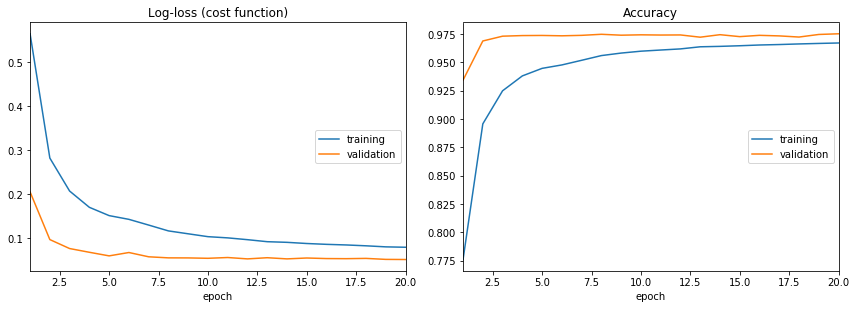

Log-loss (cost function):
training   (min:    0.080, max:    0.565, cur:    0.080)
validation (min:    0.052, max:    0.206, cur:    0.052)

Accuracy:
training   (min:    0.776, max:    0.967, cur:    0.967)
validation (min:    0.934, max:    0.975, cur:    0.975)


In [80]:
model = createModel()
history=model.fit(train_features,train_labels, epochs=20, batch_size=10,validation_data=(train_features,train_labels),callbacks=[plot_losses])

In [81]:
scores = model.evaluate(test_features, test_labels)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

172044/172044 [==============================] - 7s 42us/step

acc: 97.53%


In [82]:
predictions=model.predict_classes(test_features)
test_labels=encoder.inverse_transform(test_labels)
print(accuracy_score(test_labels, predictions))
print(confusion_matrix(test_labels, predictions))
print(classification_report(test_labels, predictions))

0.9753144544418869
[[80289   288   212   541  1107]
 [  599 34546     0     0     0]
 [  662     0 18973     0     0]
 [  235     0     0 10892     0]
 [  603     0     0     0 23097]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     82437
           1       0.99      0.98      0.99     35145
           2       0.99      0.97      0.98     19635
           3       0.95      0.98      0.97     11127
           4       0.95      0.97      0.96     23700

   micro avg       0.98      0.98      0.98    172044
   macro avg       0.97      0.98      0.97    172044
weighted avg       0.98      0.98      0.98    172044

